In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
from scipy.fft import fft, fftfreq
from sklearn import preprocessing

## Sensor Labels
    EMG 1 = a; left side of face
    EMG 2 = b; right side of face
    Ch a-d = 1-4; a-d, indicated by sensor color

In [172]:
class Emg():
    
    FSAMP = 2000
    
    def __init__(self,path = 'subject1_smile_1.xlsx'):
        self.df = pd.read_excel(path)
        self.TTIME = self.df.time.iloc[-1]
        self.NSAMP = self.df.count().a1
        self.df = self.df.set_index(self.df.time)
        self.df = self.df.drop(['time'],axis=1)
        self.RAW = self.df
        self.df = self.df*(10**6)
    def print_char(self):
        self.CHAR = {
          "T": self.TTIME,
          "N": self.NSAMP,
          "fs": self.FSAMP
        }
        print(self.CHAR)

    def plot_single(self,x,y):
        for col in self.df.columns:
            plt.figure()
            plt.plot(x,y[cols])
            plt.grid()
            plt.title('Smile: '+ '\n'+'{} '.format(col))
            plt.xlabel('time (s)')
            plt.ylabel('Voltage (uV)')
            
    def create_bandpass(self,low_band = 3, high_band = 400, order_bp = 2):
        """ return numerator, denominator = z,w of the IIR Bessel filter"""
        self.Z, self.W = sp.signal.bessel(order_bp, [low_band,high_band], btype='bandpass',analog = False, output= 'ba', fs = self.FSAMP)
        self.LOWBAND = low_band
        self.HIGHBAND = high_band
        return self.Z, self.Z
    
    def apply_bandpass(self):
        self.BANDPASSED = pd.DataFrame(columns = self.df.columns, index = self.df.index)
        for col in self.df.columns:
            self.BANDPASSED[col] = sp.signal.filtfilt(self.Z,self.W,self.df[col],padlen=0)
        return self.BANDPASSED
    
    def rectify(self):
        self.RECT = pd.DataFrame(columns = self.df.columns, index = self.df.index)
        self.RECT = np.abs(self.BANDPASSED)
        return self.RECT    
    
    def linear_envelope(self, window_size = 100):
        window = np.ones(window_size)/float(window_size)
        self.ENVELOPE = pd.DataFrame(columns = self.df.columns, index = self.df.index)
        for col in self.RECT.columns:
            self.ENVELOPE[col] = np.sqrt(np.convolve(self.RECT[col]**2,window,'same'))
        self.OUTPUT = self.ENVELOPE
        return self.ENVELOPE
    
    """def find_thresholds(self):
        threshold = 71
        var1 = []
        var2 = []
        for i in range(len(self.OUTPUT)): 
            if ((self.OUTPUT[i] <= threshold) and (self.OUTPUT[i-1] < threshold)):
                var1.append(i)
            if ((self.OUTPUT[i-1] <= threshold) and (self.OUTPUT[i] > threshold)):
                var2.append(i)
        return var1, var2"""
            
    def process(self):
        emg = Emg()
        emg.create_bandpass()
        emg.apply_bandpass()
        emg.rectify()
        self.OUTPUT = emg.linear_envelope()
        return self.OUTPUT
    
class Kin():
    
    def __init__(self,path_kin = 'subject1_smile_1_landmarks.csv',fps=100):
        self.raw = pd.read_csv(path_kin)
        self.FPS = fps
        self.raw['time'] = self.raw['Frame_number'] / self.FPS
        self.raw = self.raw.iloc[::-1]
        self.raw = self.raw.set_index('time')
        self.TTIME = self.raw.index[-1]
        self.NSAMP = self.raw['Frame_number'].values[-1]
        
        pos_top = self.raw[['landmark_62_x','landmark_62_y']].to_numpy()
        pos_bottom = self.raw[['landmark_66_x','landmark_66_y']].to_numpy()
        self.raw['deltaV'] = np.linalg.norm(pos_top - pos_bottom, axis=1)
        
        pos_left = self.raw[['landmark_51_x','landmark_51_y']].to_numpy()
        pos_right = self.raw[['landmark_57_x','landmark_57_y']].to_numpy()
        self.raw['deltaH'] = deltaH = np.linalg.norm(pos_right - pos_left, axis=1)
        
    def print_char(self):
        self.CHAR = {
          "T": self.TTIME,
          "N": self.NSAMP,
          "fs": self.FPS
        }
        print(self.CHAR)
    def plot_disp_raw(self):
        colNames = ['deltaV', 'deltaH']
        for name in colNames:
            plt.plot(self.raw.index,self.raw[name])
        plt.title('Raw deltaV and deltaH')
        
    def create_lowpass(self, low_pass_frames = 20, order = 2):
        self.Z, self.W = sp.signal.bessel(order, Wn = low_pass_frames/(self.FPS / 2), btype = 'lowpass')
        print('Output: numerator (Z) and denominator (W) of LP filter Response')
        return self.Z, self.W
    
    def apply_lowpass(self):
        cols = ['deltaV','deltaH']
        # data is a dataframe with filtered values. smaller size so we dont pass on raw always. 
        self.out_kin = pd.DataFrame(index = self.raw.index)
        for col in cols:
            self.out_kin[col] = sp.signal.filtfilt(self.Z,self.W,self.raw[col])
            
        # normalizing kinematic data. 
        normalizedV = preprocessing.normalize(self.out_kin.deltaV.values.reshape(1,-1))
        self.out_kin.deltaV = normalizedV.reshape(-1,1)
        
        normalizedH = preprocessing.normalize(self.out_kin.deltaH.values.reshape(1,-1))
        self.out_kin.deltaH = normalizedH.reshape(-1,1)
        return self.out_kin
    
class main(Emg,Kin):
    
    def visualize(df):
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('Voltage (uV)')
        ax1.plot(self.out_emg.index, self.out_emg.a1,label = 'EMG', color = 'g', alpha = 0.5)
        ax1.set_title('Smile:' +'\n' + '%s'%a3)
        ax1.tick_params(axis='y', labelcolor='g')
        ax1.tick_params(axis='y')
        ax1.yaxis.label.set_color('g') 
        leg = ax1.legend(loc = 'upper left')

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
        ax2.plot(mouthFrame/fps, distanceHoriz,'--o',label = 'Displacement', color = 'r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.yaxis.label.set_color('r') 
        leg = ax2.legend(loc = 'upper center')

        ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax3.plot(mouthFrame/fps, filt_distanceHoriz,label = 'RMS', color = 'b',alpha = 0.5)
        ax3.tick_params(axis='y', labelcolor='b')
        ax3.set_ylabel('EMG (microV)')
        leg = ax3.legend(loc = 'upper right')
        ax3.yaxis.label.set_color('b') 
        plt.ylabel("Voltage (microV)", labelpad=15)
        p3, = ax3.plot(df['time'], rms_a3, color='b', label="Voltage")
        
    def runall(self):
        emg = Emg()
        self.out_emg = emg.process()
        
        kin = Kin()
        kin.create_lowpass()
        self.out_kin = kin.apply_lowpass()
        

In [173]:
m = main()
out = m.runall()
out

Output: numerator (Z) and denominator (W) of LP filter Response


In [174]:
m.out_kin

,deltaV,deltaH
time,,
0.00,0.004515,0.014705
0.01,0.004188,0.014588
0.02,0.004062,0.014585
0.03,0.004190,0.014760
0.04,0.004369,0.015045
...,...,...
27.35,0.001707,0.013981
27.36,0.001706,0.014117
27.37,0.001623,0.014165


In [175]:
m.out_emg

,a1,a2,a3,a4,b1,b2,b3,b4
time,,,,,,,,
0.0000,3.875326,5.529149,4.951291,4.686864,3.075379,10.077514,2.449169,3.516867
0.0005,3.915677,5.580736,4.976485,4.698259,3.084133,10.290070,2.456378,3.552205
0.0010,3.949768,5.649743,5.002898,4.717218,3.095258,10.523841,2.461028,3.595939
0.0015,3.976041,5.730427,5.030437,4.748348,3.114958,10.736159,2.466006,3.655218
0.0020,3.995975,5.807806,5.060150,4.790211,3.153382,10.887676,2.470424,3.726788
...,...,...,...,...,...,...,...,...
27.4945,0.104172,0.141215,0.158062,0.136885,0.086923,0.074001,0.079691,0.042851
27.4950,0.102481,0.138960,0.155410,0.134670,0.085484,0.072982,0.078371,0.042140
27.4955,0.100752,0.136651,0.152704,0.132404,0.084014,0.071927,0.077022,0.041415


<IPython.core.display.Javascript object>


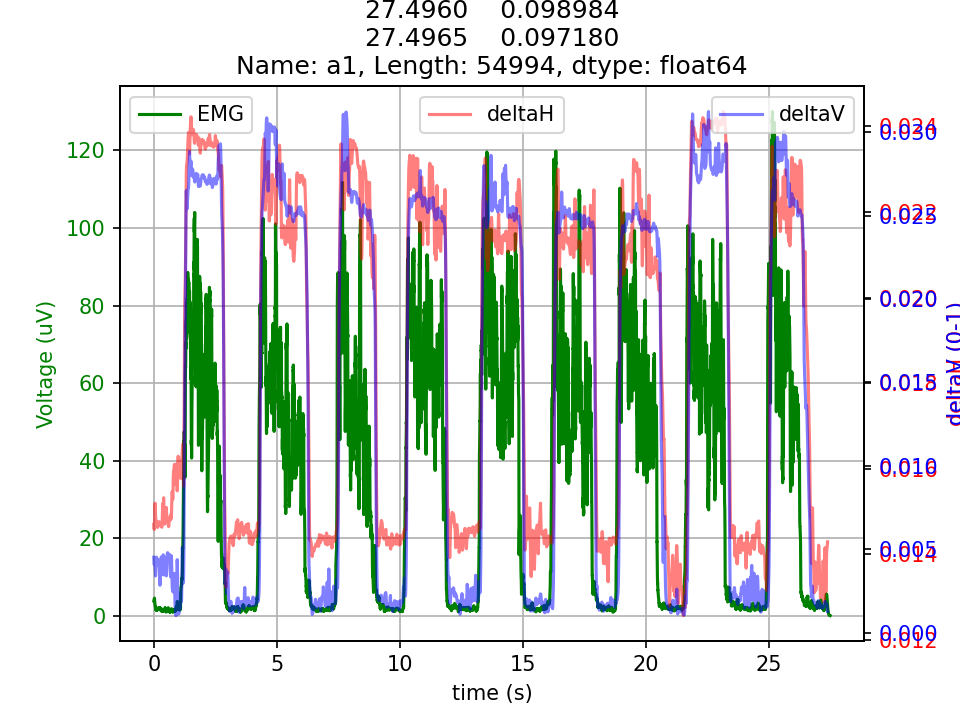

In [191]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel('Voltage (uV)')
ax1.plot(m.out_emg.index, m.out_emg.a1,label = 'EMG', color = 'g', alpha = 1)
ax1.set_title('Smile:' +'\n' + '%s'%m.out_emg.a1)
ax1.tick_params(axis='y', labelcolor='g')
ax1.tick_params(axis='y')
ax1.yaxis.label.set_color('g') 
leg = ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('deltaH (0-1)')  # we already handled the x-label with ax1
ax2.plot(m.out_kin.index, m.out_kin.deltaH,label = 'deltaH', color = 'r', alpha = 0.5)
ax2.tick_params(axis='y', labelcolor='r')
ax2.yaxis.label.set_color('r') 
leg = ax2.legend(loc = 'upper center')

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot(m.out_kin.index, m.out_kin.deltaV,label = 'deltaV', color = 'b',alpha = 0.5)
ax3.tick_params(axis='y', labelcolor='b')
ax3.set_ylabel('deltaV (0-1)')
leg = ax3.legend(loc = 'upper right')
ax3.yaxis.label.set_color('b') 
ax1.grid()
#plt.ylabel("Voltage (microV)", labelpad=15)
#p3, = ax3.plot(df['time'], rms_a3, color='b', label="Voltage")